tfds.core.DatasetInfo(
    name='beans',
    version=0.1.0,
    description='Beans is a dataset of images of beans taken in the field using smartphone
cameras. It consists of 3 classes: 2 disease classes and the healthy class.
Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated
by experts from the National Crops Resources Research Institute (NaCRRI) in
Uganda and collected by the Makerere AI research lab.',
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=1295,
    splits={
        'test': 128,
        'train': 1034,
        'validation': 133,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {beansdata,
        author="Makerere AI Lab",
        title="Bean disease dataset",
        month="January",
        year="2020",
        url="https://git

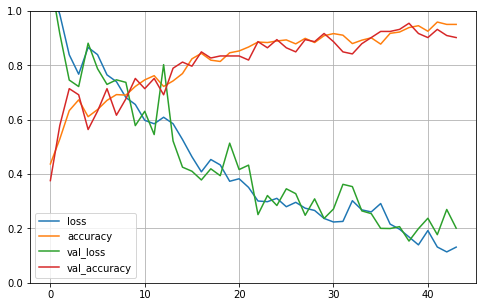

2/2 [==============================] - 1s 300ms/step - loss: 0.2658 - accuracy: 0.9141
[0.26575201749801636, 0.9140625]


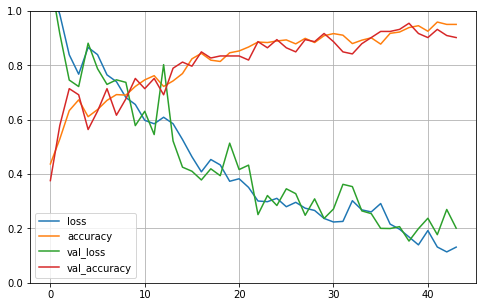

In [ ]:

import tensorflow as tf
import tensorflow_datasets as tfds
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import string, random
import pandas as pd

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

prjectName = 'beans'
def retrive_data():
    test_ds, info = tfds.load(prjectName, split='test', as_supervised=True, with_info=True, shuffle_files=True)
    print(info)
    # to see labels
    print(f'Classes:{info.features["label"].names}')
    # show the shape
    print(test_ds.element_spec)
    return test_ds, info

def get_training_data():
    validation_data = tfds.load(prjectName, split=f'validation', as_supervised=True)
    training_data = tfds.load(prjectName, split=f'train', as_supervised=True)
    return training_data, validation_data

def wrangle_data_GenPlus(dataset, split, batch_size=32):
    wrangled = dataset.map(lambda img, lbl: (tf.cast(img,tf.float32)/255.0,lbl))
    if split == 'train':
        features = np.array([x[0] for x in wrangled])
        lables = np.array([x[1] for x in wrangled])
        train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            horizontal_flip=True,
            zoom_range = 0.2,
            rotation_range=20,
            fill_mode='nearest'
        )
        wrangled = train_data_gen.flow(features, lables,batch_size=batch_size)
    elif split in ('valid','test' ) : # Caches the elements in this dataset. loat it into the memory to go faster
        wrangled = wrangled.cache()
        wrangled = wrangled.batch(batch_size)  # Combines consecutive elements of this dataset into batches.
        wrangled = wrangled.prefetch(tf.data.AUTOTUNE)
    return wrangled

def compileModel(model):
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  # classification with integer encoded labels use "scce"
                  metrics=['accuracy'])
    print(model.summary())
    return model

def myFullCNN():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer((500, 500, 3)),
        tf.keras.layers.experimental.preprocessing.Resizing(125,125),
        tf.keras.layers.Conv2D(64, 3, activation=tf.keras.activations.relu),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, 3, activation=tf.keras.activations.relu),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, activation=tf.keras.activations.relu),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, activation=tf.keras.activations.relu),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, activation=tf.keras.activations.relu),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(3, activation=tf.keras.activations.softmax)
    ], name='cnn_model')
    return compileModel(model)


def plot_History(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()


if __name__ == "__main__":
    # prepare the data
    test_ds, info = retrive_data()
    train_ds, valid_ds = get_training_data()


    
    batch_size = 64
    train_data = wrangle_data_GenPlus(train_ds, 'train', batch_size=batch_size)
    valid_data = wrangle_data_GenPlus(valid_ds, 'valid', batch_size=batch_size)
    test_data = wrangle_data_GenPlus(test_ds, 'test', batch_size=batch_size)
    
    # advancedCNN
    model = myFullCNN()

    # fit the model
    history = model.fit(train_data, validation_data=valid_data, epochs=70)

    plot_history(history)
    print(model.evaluate(test_data))

    plot_History(history)